In [68]:
import librosa
from glob import glob
import numpy as np
from sklearn.cluster import KMeans
import math

In [69]:
base_path=r"C:\Users\Asus\Documents\GitHub\Speaker_Verification"
model_save_path=r"C:\Users\Asus\Documents\GitHub\Speaker_Verification\VQ PATH\\"
train_path= base_path + '\\' + 'Sample_train_data'
test_path=  base_path + '\\' + 'Sample_test_data'

In [70]:
code_book_sz=64

In [71]:
train_files_1 = glob(train_path+"\*\*_AH01OENC.wav")
train_files_2 = glob(train_path+"\*\*_AH01MENC.wav")
train_files = train_files_1 + train_files_2
train_files.sort()

In [72]:
len(train_files)

5

In [73]:
test_files_1 = glob(test_path+"\*\*_AH01OENC_03*")
test_files_2 = glob(test_path+"\*\*_AH01MENC_03*")
test_files_3 = glob(test_path+"\*\*_AH01OENC_04*")
test_files_4 = glob(test_path+"\*\*_AH01MENC_04*")
test_files = test_files_1 + test_files_2 + test_files_2 + test_files_4
test_files.sort()

In [74]:
len(test_files)

5

In [75]:
VQM =[]
for i in range(len(train_files)):
 audio_data, fs = librosa.load(train_files[i],sr=8000)

 audio_data=audio_data-np.mean(audio_data)
 audio_data=audio_data/(1.01*(max(abs(audio_data))))

 MFCC    = librosa.feature.mfcc(y=audio_data,sr=fs, n_mfcc=14, lifter=1,dct_type=3,hop_length=int(0.01*fs), win_length=int(0.02*fs),window='hann', n_mels=24)
 MFCC_d  = librosa.feature.delta(MFCC, order=1)
 MFCC_dd = librosa.feature.delta(MFCC, order=2)

 MFCC=MFCC.T
 MFCC_d=MFCC_d.T
 MFCC_dd=MFCC_dd.T

 MFCC=MFCC[:,1:14]
 MFCC_d=MFCC_d[:,1:14]
 MFCC_dd=MFCC_dd[:,1:14]

 X = np.concatenate((MFCC, MFCC_d), axis=1)
 X = np.concatenate((X, MFCC_dd), axis=1)

 vectors=KMeans(n_clusters=code_book_sz,random_state=42).fit(X)
 VQM.append(vectors)

 print('Training for SPK ',i,' completed')

Training for SPK  0  completed
Training for SPK  1  completed
Training for SPK  2  completed
Training for SPK  3  completed
Training for SPK  4  completed


In [76]:
import pickle
for i in range(len(train_files)):
 print(i)
 pickle.dump(VQM[i], open(model_save_path+"VQ_"+str(i)+'.pkl', "wb"))

0
1
2
3
4


Test

In [77]:
def distance(Cen_vq,MFCC):
  filedist=[]
  for i in range(len(MFCC)):
    framedist=[]
    for j in range(len(Cen_vq)):
       framedist.append(math.sqrt(sum((MFCC[i,:]-Cen_vq[j,:])**2)))
    filedist.append(min(framedist))
  dist = np.mean(filedist)
  return dist

In [78]:
Score = []
for i in range(len(test_files)):
 audio_data, fs = librosa.load(test_files[i],sr=8000)

 audio_data=audio_data-np.mean(audio_data)
 audio_data=audio_data/(1.01*(max(abs(audio_data))))

 MFCC=librosa.feature.mfcc(y=audio_data,sr=fs, n_mfcc=14, lifter=1,dct_type=3,hop_length=int(0.01*fs), win_length=int(0.02*fs),window='hann', n_mels=24)
 MFCC_d  = librosa.feature.delta(MFCC, order=1)
 MFCC_dd = librosa.feature.delta(MFCC, order=2)

 MFCC=MFCC.T
 MFCC_d=MFCC_d.T
 MFCC_dd=MFCC_dd.T

 MFCC=MFCC[:,1:14]
 MFCC_d=MFCC_d[:,1:14]
 MFCC_dd=MFCC_dd[:,1:14]

 X = np.concatenate((MFCC, MFCC_d), axis=1)
 X = np.concatenate((X, MFCC_dd), axis=1)

 for j in range(len(VQM)):
  Cen_vq=pickle.load(open(model_save_path+"VQ_"+str(j)+".pkl", "rb"))
  dist = distance(Cen_vq.cluster_centers_,X)
  Score.append(dist)
  print(len(Score))
Score = np.reshape(Score,(len(test_files),len(VQM)))  

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [79]:
len(test_files)

5

In [80]:
import librosa
from glob import glob
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score
import os

#def compute_eer(label, pred, positive_label=1):

#    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred)
#    fnr = 1 - tpr

#    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

#    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
#    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

#    eer = (eer_1 + eer_2) / 2
#    return eer

#base_path='/home/pi/speaker_recognition/SR'
#test_path=  base_path + '/' + 'Test_Folder'

cl_sz=64

#test_files_1 = glob(test_path+"/*/*_AH01OENC*")
#test_files_2 = glob(test_path+"/*/*_AH01MENC*")
#test_files = test_files_1 + test_files_2
#test_files.sort()

true = []
for i in range(len(test_files)):
  true.append(test_files[i].split('\\')[7])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
true = le.fit_transform(true)

Score = []
speaker=[]
pred = []
prob=[]
for i in range(len(test_files)):
 audio_data, fs = librosa.load(test_files[i],sr=8000)

 audio_data=audio_data-np.mean(audio_data)
 audio_data=audio_data/(1.01*(max(abs(audio_data))))

 MFCC=librosa.feature.mfcc(y=audio_data,sr=fs, n_mfcc=14, lifter=1,dct_type=3,hop_length=int(0.01*fs), win_length=int(0.02*fs),window='hann', n_mels=24)
 MFCC_d  = librosa.feature.delta(MFCC, order=1)
 MFCC_dd = librosa.feature.delta(MFCC, order=2)

 MFCC=MFCC.T
 MFCC_d=MFCC_d.T
 MFCC_dd=MFCC_dd.T

 MFCC=MFCC[:,1:14]
 MFCC_d=MFCC_d[:,1:14]
 MFCC_dd=MFCC_dd[:,1:14]

 X = np.concatenate((MFCC, MFCC_d), axis=1)
 X = np.concatenate((X, MFCC_dd), axis=1)

 for j in range(len(os.listdir(model_save_path))):
  Cen_vq=pickle.load(open(model_save_path+"VQ_"+str(j)+".pkl", "rb"))
  dist = distance(Cen_vq.cluster_centers_,X)
  Score.append(dist)
 pred_label = np.argmin(Score) 
 if(pred_label == true[i]):
   pred.append(1)
 else:
   pred.append(0)  
 prob.append(abs(min(Score)))  
 speaker.append(pred_label)
 Score=[]
 print("Testing of Utterence "+str(i)+" completed")

#eer = compute_eer(pred, prob)
#print('The equal error rate is {:.3f}'.format(eer))

print("The Accuracy is ", accuracy_score(true, speaker))


Testing of Utterence 0 completed
Testing of Utterence 1 completed
Testing of Utterence 2 completed
Testing of Utterence 3 completed
Testing of Utterence 4 completed
The Accuracy is  1.0


<AxesSubplot: >

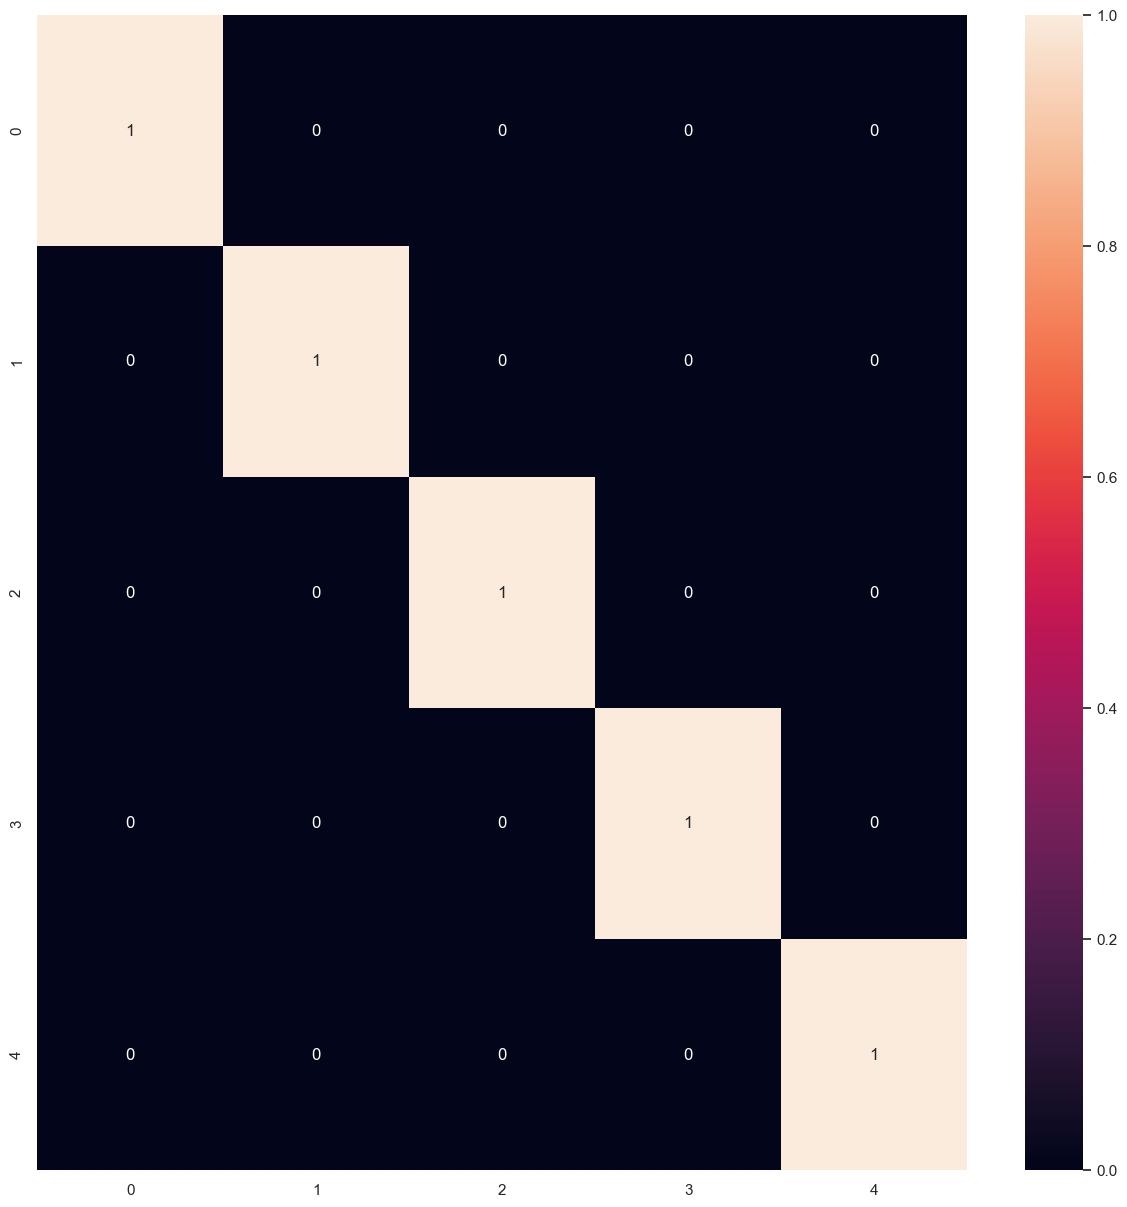

In [81]:
from sklearn.metrics import confusion_matrix
CM=confusion_matrix(true, speaker)
import seaborn as sb
sb.heatmap(CM, annot=True, fmt="d")